In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# set seed to reproduce similar results
np.random.seed(0)

In [5]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + './human+activity+recognition+using+smartphones/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + './human+activity+recognition+using+smartphones/UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [6]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [7]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


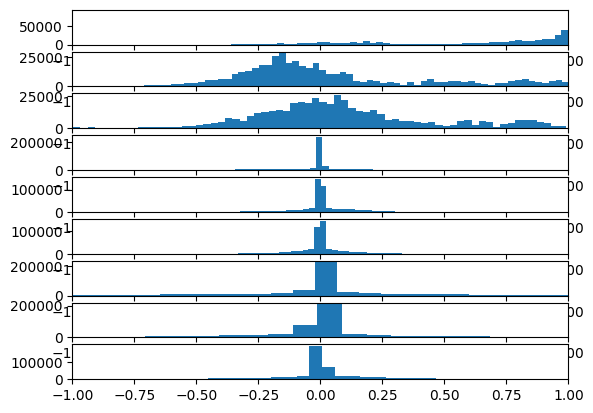

In [8]:
# plot distributions
plot_distributions(trainX)

In [9]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [10]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 11s 105ms/step - loss: 1.2069 - accuracy: 0.4863 - val_loss: 0.9941 - val_accuracy: 0.6356
Epoch 2/10
92/92 [==============================] - 10s 104ms/step - loss: 0.8277 - accuracy: 0.6385 - val_loss: 0.8362 - val_accuracy: 0.6968
Epoch 3/10
92/92 [==============================] - 10s 104ms/step - loss: 0.6837 - accuracy: 0.7159 - val_loss: 1.2836 - val_accuracy: 0.6064
Epoch 4/10
92/92 [==============================] - 10s 112ms/step - loss: 0.6830 - accuracy: 0.7176 - val_loss: 0.8023 - val_accuracy: 0.7471
Epoch 5/10
92/92 [==============================] - 11s 122ms/step - loss: 0.5061 - accuracy: 0.7949 - val_loss: 0.6734 - val_accuracy: 0.7845
Epoch 6/10
92/92 [==============================] - 10s 113ms/step - loss: 0.4010 - accuracy: 0.8543 - val_loss: 0.6757 - val_accuracy: 0.8008
Epoch 7/10
92/92 [==============================] - 10s 110ms/step - loss: 0.2958 - accuracy: 0.8987 - val_loss: 0.5414 - val_accuracy: 0.8457

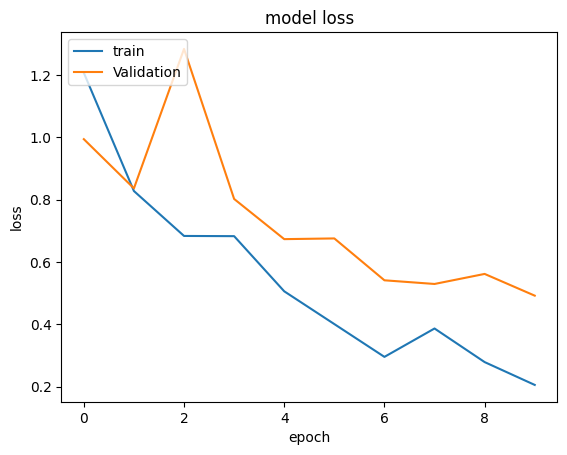

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [14]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the LSTM model 0.8710553050041199
93/93 [==============================] - 2s 13ms/step


In [15]:
predictions

array([[2.8635946e-03, 1.3335512e-04, 9.0277172e-05, 1.3745253e-02,
        9.8315465e-01, 1.2916885e-05],
       [3.3121926e-03, 1.4518117e-04, 9.1824681e-05, 1.2785188e-02,
        9.8365372e-01, 1.1815494e-05],
       [3.5375685e-03, 1.5154498e-04, 9.1802976e-05, 1.1783105e-02,
        9.8442519e-01, 1.0817183e-05],
       ...,
       [2.1863109e-02, 9.7058904e-01, 7.4554738e-03, 1.2225482e-05,
        7.4668722e-05, 5.4337288e-06],
       [2.9515704e-02, 9.6505785e-01, 5.1546078e-03, 4.5012188e-05,
        1.9888303e-04, 2.7972461e-05],
       [1.4258327e-01, 8.4262025e-01, 1.2577013e-02, 5.2637554e-04,
        1.4435742e-03, 2.4956823e-04]], dtype=float32)

In [16]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[486   8   1   0   1   0]
 [ 82 362  27   0   0   0]
 [ 11  24 385   0   0   0]
 [  2   0   0 414  75   0]
 [  4   1   0 115 412   0]
 [  9  19   1   0   0 508]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.82      0.98      0.89       496
           2       0.87      0.77      0.82       471
           3       0.93      0.92      0.92       420
           4       0.78      0.84      0.81       491
           5       0.84      0.77      0.81       532
           6       1.00      0.95      0.97       537

    accuracy                           0.87      2947
   macro avg       0.87      0.87      0.87      2947
weighted avg       0.88      0.87      0.87      2947



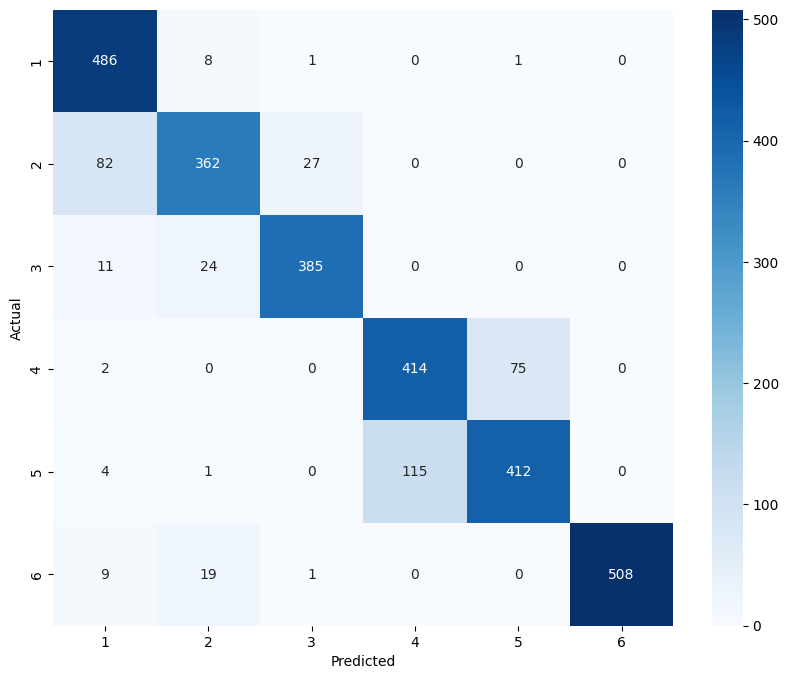

In [17]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

In [18]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
# fit network
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
92/92 [==============================] - 3s 27ms/step - loss: 0.4731 - accuracy: 0.8157 - val_loss: 0.4744 - val_accuracy: 0.8790
Epoch 2/20
92/92 [==============================] - 2s 26ms/step - loss: 0.1559 - accuracy: 0.9388 - val_loss: 0.4182 - val_accuracy: 0.9082
Epoch 3/20
92/92 [==============================] - 2s 21ms/step - loss: 0.1138 - accuracy: 0.9541 - val_loss: 0.4670 - val_accuracy: 0.9048
Epoch 4/20
92/92 [==============================] - 2s 22ms/step - loss: 0.1039 - accuracy: 0.9578 - val_loss: 0.4587 - val_accuracy: 0.9116
Epoch 5/20
92/92 [==============================] - 2s 27ms/step - loss: 0.0928 - accuracy: 0.9568 - val_loss: 0.5138 - val_accuracy: 0.8933
Epoch 6/20
92/92 [==============================] - 2s 26ms/step - loss: 0.0793 - accuracy: 0.9643 - val_loss: 0.5861 - val_accuracy: 0.9123
Epoch 7/20
92/92 [==============================] - 2s 23ms/step - loss: 0.0754 - accuracy: 0.9638 - val_loss: 0.6195 - val_accuracy: 0.9116
Epoch 8/20
92

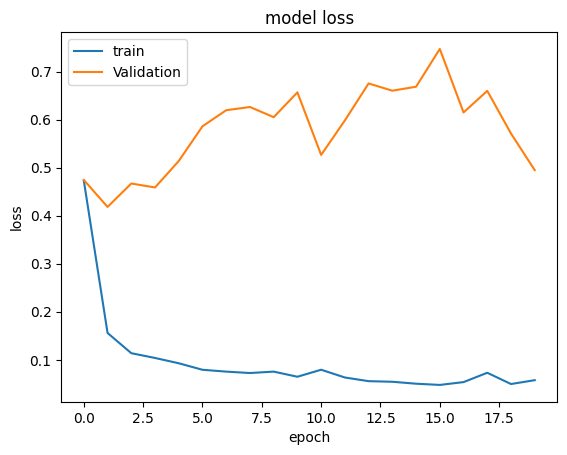

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [22]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the CNN model 0.917203962802887
93/93 [==============================] - 0s 4ms/step


**** Confusion Matrix ****
[[479   5  12   0   0   0]
 [  4 443  24   0   0   0]
 [  6  12 402   0   0   0]
 [  1  25   0 403  62   0]
 [  1   8   0  57 466   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.98      0.97      0.97       496
           2       0.85      0.94      0.89       471
           3       0.92      0.96      0.94       420
           4       0.88      0.82      0.85       491
           5       0.88      0.88      0.88       532
           6       1.00      0.95      0.97       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



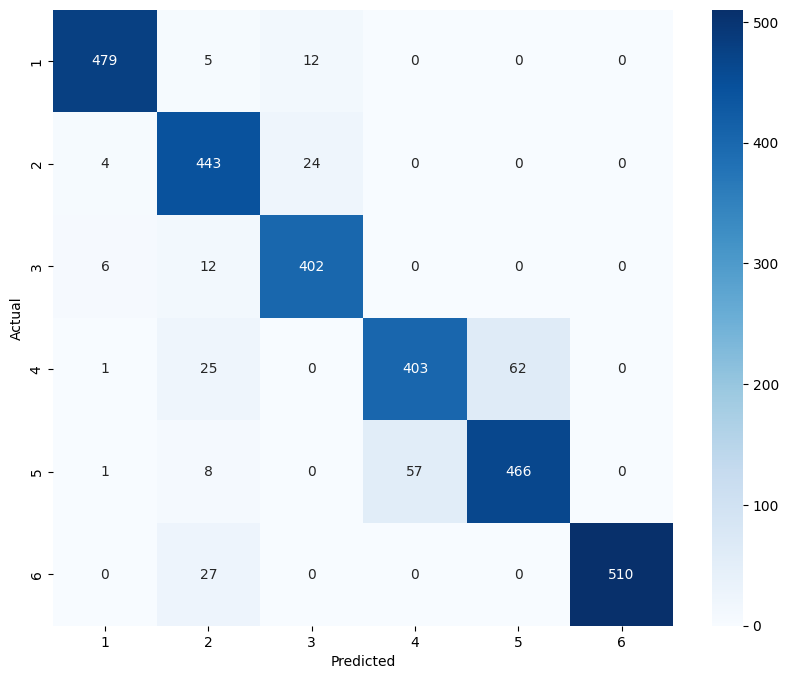

In [23]:
display_results(testy,predictions,classNames)

In [24]:
# we will select the first sample from the test set
sample = testX[0]
sample.shape

(128, 9)

In [25]:
# predict the results using the model, we need to input in the form of (numberOfSamples,featureLength,numberOfFeatures)
predictionForSample = model.predict(sample.reshape(1,sample.shape[0],sample.shape[1]))

1/1 [==============================] - 0s 19ms/step


In [26]:
# get the class of the sample
samplePredictedClass = np.argmax(predictionForSample, axis=1)
sampleActualClass = np.argmax(testy, axis=1)
print("Actual class: ",sampleActualClass[0])
print("Predicted class: ",samplePredictedClass[0])

Actual class:  4
Predicted class:  4
